# Basic Temperature Features #

Temperature is a very important parameter in hydrogen transport. The value can be a simple float (like here `300`) or a sympy expression like `500 + 3*numpy.xp(-F.x)`.

The temperature is in K.

Objectives:
* Define temperature as a fixed value
* Define time dependent temperature values
* Define temperature as a FEniCS Function

<!-- Defined as space-dependent
Defined both space and time dependent
read from external solver, link to multiphysics coupling
read from internal solver HeatTransferProblem steady state (link to previous bullet)
read from internal solver but transient (third problem class) -->

## Defining fixed temperature values ##

Consider the following 1D example

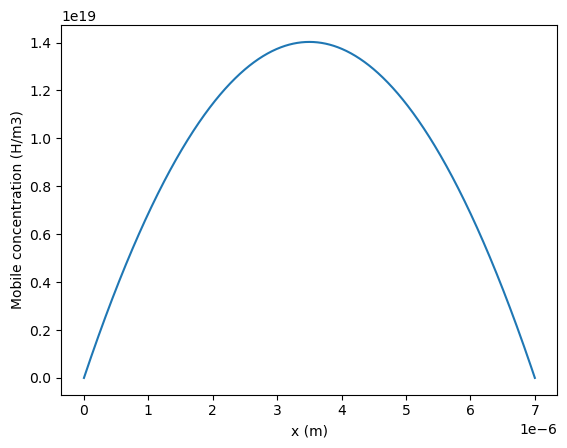

In [36]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 7e-6, num=1001))
mat = F.Material(D_0=1e-7, E_D=0.2)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 7e-6], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]
H = F.Species("H")
my_model.species = [H]
my_model.temperature = 300
my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]

my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=2)  # s

my_model.settings.transient = False
my_model.settings.stepsize = None

class ProfileExport(F.VolumeQuantity):

    def compute(self):
        profile = self.field.solution.x.array[:].copy()

        self.data.append(profile)


profile = ProfileExport(field=H, volume=volume_subdomain)

my_model.exports = [profile]
my_model.initialise()

my_model.run()

import matplotlib.pyplot as plt
import numpy as np

x = my_model.mesh.mesh.geometry.x[:, 0]
data = profile.data[0]
plt.plot(x, data)
plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.show()

To how changing the temperature affects the concentration profile, let's plot the results for 300 K, 400 K, and 500 K:

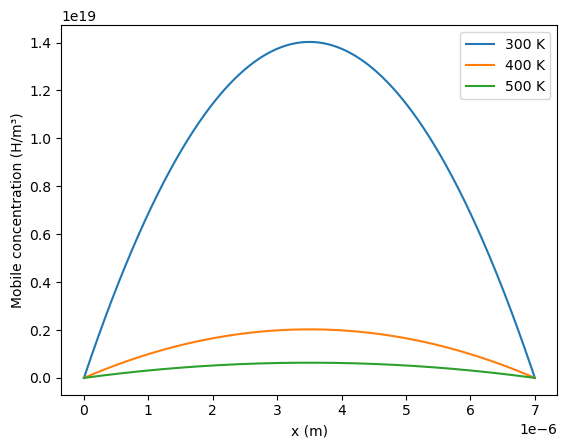

In [38]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

temperatures = [300, 400, 500]

for temp in temperatures:
    my_model = F.HydrogenTransportProblem()

    my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 7e-6, num=1001))
    mat = F.Material(D_0=1e-7, E_D=0.2)

    volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 7e-6], material=mat)
    boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
    boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
    my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]

    H = F.Species("H")
    my_model.species = [H]
    my_model.temperature = temp

    my_model.boundary_conditions = [
        F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
        F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
    ]

    my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
    my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=2)
    my_model.settings.transient = False
    my_model.settings.stepsize = None

    class ProfileExport(F.VolumeQuantity):
        def compute(self):
            profile = self.field.solution.x.array[:].copy()
            self.data.append(profile)

    profile = ProfileExport(field=H, volume=volume_subdomain)
    my_model.exports = [profile]

    my_model.initialise()
    my_model.run()

    # Plot each result with a label for the temperature
    x = my_model.mesh.mesh.geometry.x[:, 0]
    data = profile.data[0]
    plt.plot(x, data, label=f"{temp} K")

# Finalize the plot after loop
plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m³)")
plt.legend()
plt.show()


## Time-dependent temperature values ##

There are two ways of doing this: definign as a lambda or function

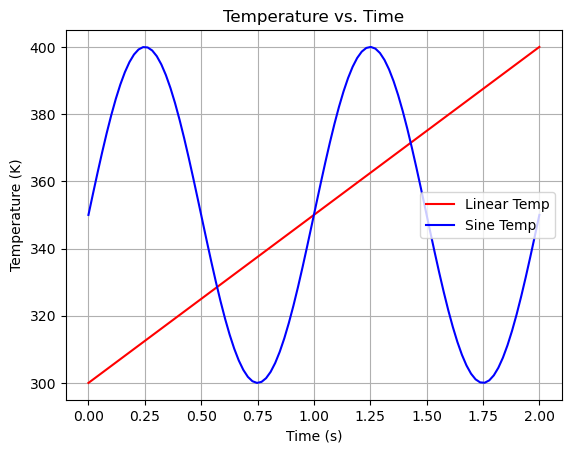

In [85]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

my_model = F.HydrogenTransportProblem()
times = np.linspace(0, 2, 100)

# Option 1: simple Python time-dependent function
my_model.temperature = lambda t: 300 + 50*t

# Evaluate for plotting
linear_temp = [my_model.temperature(t) for t in times]

# Option 2: using symbolic expression
def temp_function(t):
    return 350 + 50*np.sin(2*np.pi*t) 

my_model = F.HydrogenTransportProblem()

my_model.temperature = temp_function
sine_temp = [my_model.temperature(t) for t in times]

# Plot both
plt.plot(times, linear_temp, 'r-', label="Linear Temp")
plt.plot(times, sine_temp, 'b-', label="Sine Temp")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs. Time")
plt.legend()
plt.grid(True)
plt.show()


Solving HydrogenTransportProblem:   0%|          | 0.00/5.00 [00:00<?, ?it/s]

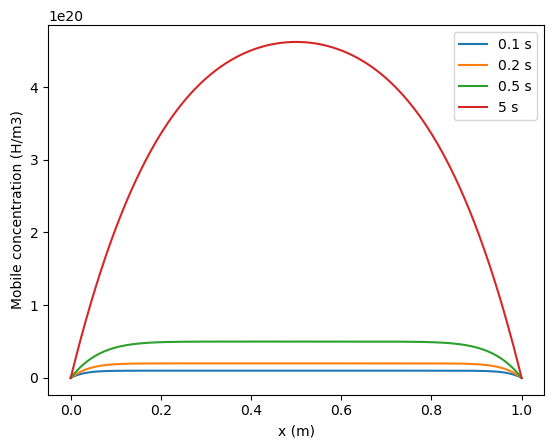

In [100]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

my_model = F.HydrogenTransportProblem()
times = np.linspace(0, 2, 100)

my_model.temperature = lambda t: 200 + 50*t

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 1, num=1001))
mat = F.Material(D_0=1e-2, E_D=0)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=1)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]
H = F.Species("H")
my_model.species = [H]

my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]

my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=5)  # s
my_model.settings.stepsize = F.Stepsize(0.05, milestones=[0.1, 0.2, 0.5, 5])  # s

class ProfileExport(F.VolumeQuantity):

    def compute(self):
        profile = self.field.solution.x.array[:].copy()
        self.data.append(profile)


profile = ProfileExport(field=H, volume=volume_subdomain)

my_model.exports = [profile]
my_model.initialise()

my_model.run()

import matplotlib.pyplot as plt
import numpy as np

x = my_model.mesh.mesh.geometry.x[:, 0]
times=profile.t

for t in [0.1, 0.2, 0.5, 5]:
    idx = np.where(np.isclose(profile.t, t))[0][0]
    data = profile.data[idx]
    plt.plot(x, data, label=f"{t} s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()



In [72]:
import ufl
my_model.temperature = lambda t, x: 300*t + 100 * ufl.sin(2*ufl.pi*x[0])


## Space-dependent temperature values ##

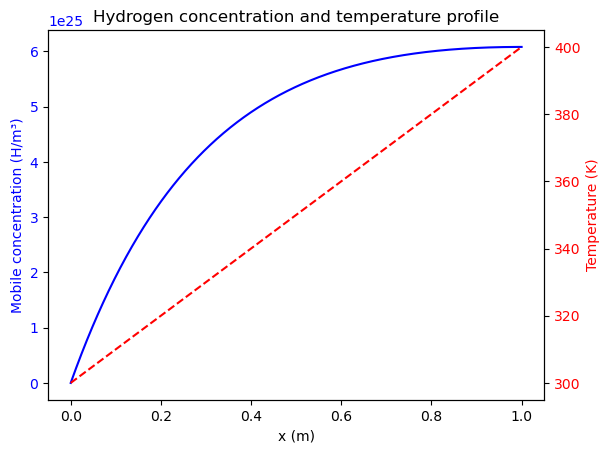

In [52]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

my_model = F.HydrogenTransportProblem()

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 1, num=1001))
mat = F.Material(D_0=1e-3, E_D=0.2)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]
H = F.Species("H")
my_model.species = [H]

x = my_model.mesh.mesh.geometry.x[:, 0]
my_model.temperature = lambda x: 300 + 100 * x[0]  # spatially varying temperature

my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]

my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=2)  # s
my_model.settings.transient = False
my_model.settings.stepsize = None

class ProfileExport(F.VolumeQuantity):
    def compute(self):
        profile = self.field.solution.x.array[:].copy()
        self.data.append(profile)

profile = ProfileExport(field=H, volume=volume_subdomain)
my_model.exports = [profile]

my_model.initialise()
my_model.run()

# Extract results
data = profile.data[0]
T_profile = [my_model.temperature([xi]) for xi in x]  # evaluate temperature at each x

# Plot with dual y-axes
fig, ax1 = plt.subplots()

ax1.plot(x, data, "b-", label="H concentration")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("Mobile concentration (H/m³)", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(x, T_profile, "r--", label="Temperature")
ax2.set_ylabel("Temperature (K)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.title("Hydrogen concentration and temperature profile")
plt.show()


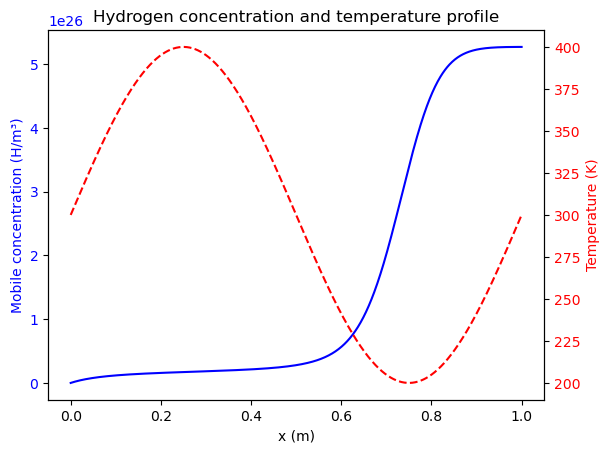

In [ ]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt
import ufl

my_model = F.HydrogenTransportProblem()

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 1, num=1001))
mat = F.Material(D_0=1e-3, E_D=0.2)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]
H = F.Species("H")
my_model.species = [H]

x = my_model.mesh.mesh.geometry.x[:, 0]

my_model.temperature = lambda x: 300 + 100 * ufl.sin(2 * ufl.pi * x[0])

my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]

my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=2)  # s
my_model.settings.transient = False
my_model.settings.stepsize = None

class ProfileExport(F.VolumeQuantity):
    def compute(self):
        profile = self.field.solution.x.array[:].copy()
        self.data.append(profile)

profile = ProfileExport(field=H, volume=volume_subdomain)
my_model.exports = [profile]

my_model.initialise()
my_model.run()

# Extract results
data = profile.data[0]
T_profile = [my_model.temperature([xi]) for xi in x]  # evaluate temperature at each x

# Plot with dual y-axes
fig, ax1 = plt.subplots()

ax1.plot(x, data, "b-", label="H concentration")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("Mobile concentration (H/m³)", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(x, T_profile, "r--", label="Temperature")
ax2.set_ylabel("Temperature (K)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.title("Hydrogen concentration and temperature profile")
plt.show()
